<a href="https://colab.research.google.com/github/Nirzu97/pyprobml/blob/linalg/notebooks/linalg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear algebra

## TOC:
* [Basics](#basics)
* [Sparse matrices](#sparse)
* [Broadcasting](#broadcasting)
* [Einstein summation](#einstein)
* [Eigenvalue decomposition](#EVD)
* [Singular value decomposition](#SVD)
* [Other decompositions](#decomp)
* [Matrix calculus](#calculus)
* [Linear systems of equations](#linear)


In [ ]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import numpy as np
np.set_printoptions(precision=3)
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

import sklearn

import seaborn as sns;
sns.set(style="ticks", color_codes=True)

import pandas as pd
pd.set_option('precision', 2) # 2 decimal places
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100) # wide windows



In [ ]:
# https://github.com/google/jax
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax import grad, hessian, jacfwd, jacrev, jit, vmap
from jax.experimental import optimizers
print("jax version {}".format(jax.__version__))

jax version 0.2.12


## Basics <a class="anchor" id="basics"></a>

In [ ]:
# Create 1d vector
v = jnp.array([0,1,2]) # 1d vector
print(v.ndim) ## 1
print(v.shape) ## (3,)


1
(3,)


In [ ]:
# Note that Python uses 0-indexing, not 1-indexing.
# Thus the elements are accessed as follows:
print(v[0], v[1], v[2]) ## 0 1 2

0 1 2


In [ ]:
# Create 2d array
A = jnp.array([ [0,1,2], [3,4,5] ]) 
print(A)
## [[0, 1, 2],
##  [3, 4, 5]])
print(A.ndim) ## 2
print(A.shape) ## (2,3)
print(A.size) ## 6
print(A.T.shape) ## (3,2)

[[0 1 2]
 [3 4 5]]
2
(2, 3)
6
(3, 2)


In [ ]:
# If we want to make a vector into a matrix with one row, we can use any of the following:

x = jnp.array([1,2]) # vector
X1 = jnp.array([x]) # matrix with one row
X2 = jnp.reshape(x, (1,-1))
X3 = x[None, :]
X4 = x[jnp.newaxis, :]
assert jnp.array_equal(X1, X2)
assert jnp.array_equal(X1, X3)
print(jnp.shape(X1)) ## (1,2)


(1, 2)


In [ ]:
# If we want to make a vector into a matrix with one column, we can use any of the following:
x = jnp.array([1,2]) # vector
X1 = jnp.array([x]).T # matrix with one column
X2 = jnp.reshape(x, (-1,1))
X3 = x[:, None]
X4 = x[:, jnp.newaxis]
assert jnp.array_equal(X1, X2)
assert jnp.array_equal(X1, X3)
print(jnp.shape(X1)) ## (2,1)

(2, 1)


In [ ]:
# Here is how to create a one-hot encoding of integers.

def one_hot(x, k, dtype=jnp.float32):
  return jnp.array(x[:, None] == jnp.arange(k), dtype)


# Example
x = jnp.array([1,2,0,2]);
X = one_hot(x, 3)
print(X)



[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [ ]:

# We can construct arrays from a list of column vectors as follows:
A1 = jnp.array([ [0,1,2], [3,4,5] ]) 
col0 = A1[:,0]; col1 = A1[:,1]; col2=A1[:,2];
A2 = jnp.stack([col0,col1,col2],axis=1)
assert jnp.array_equal(A1, A2)

# We can construct arrays from a list of row vectors as follows:
row0=A1[0,:]; row1=A1[1,:];
A2 = jnp.stack([row0,row1],axis=0)
assert jnp.array_equal(A1, A2)

In [ ]:
# We can construct arrays from a list of arrays
# using the hstack or vstack functions,
# which stack horizontally or vertically,  as illustrated below.

M = jnp.array([[9,8,7],[6,5,4]])
C = jnp.array([[99], [99]])
A1 = jnp.concatenate([M, C], axis=1)
A2 = jnp.hstack([M, C])
#A3 = jnp.c_[M, C] # c_ does not work in jax
assert jnp.array_equal(A1, A2)
#assert jnp.array_equal(A1, A3)
print(A1)



[[ 9  8  7 99]
 [ 6  5  4 99]]


In [ ]:

R = jnp.array([[1,2,3]])
A1 = jnp.concatenate([R, M], axis=0)
A2 = jnp.vstack([R, M])
assert jnp.array_equal(A1, A2)
print(A1)


[[1 2 3]
 [9 8 7]
 [6 5 4]]


In [ ]:
# A very common idiom  is to add a column of 1s to a datamatrix.
# We can do this using horizontal stacking (along the columns) as follows.

X = jnp.array([[9,8,7],[6,5,4]])
N = jnp.shape(X)[0] # num. rows
X1 = jnp.hstack([jnp.ones((N,1)), X])
print(X1)

[[1. 9. 8. 7.]
 [1. 6. 5. 4.]]


In [ ]:

# We can flatten a matrix to a vector (concatenating its rows, one by one) using ravel

A = jnp.reshape(jnp.arange(6),(2,3))
print(A.ravel()) ##  [0 1 2 3 4 5]


[0 1 2 3 4 5]


In numpy,  arrays are layed out in memory
such that, if we iterate over neighboring elements,
the rightmost index changes the fastest.
This is called row-major order,
and is used by other languages such as C++, Eigen and PyTorch.
By contrast, other languages (such as Julia, Matlab, R and Fortran)
use column-major order.
See below for an illustration of the difference.


<img src="https://upload.wikimedia.org/wikipedia/commons/4/4d/Row_and_column_major_order.svg" width="200">


(Source: https://commons.wikimedia.org/wiki/File:Row_and_column_major_order.svg)

Thus in numpy, for speed reasons, we should always write loops like this:
```
A = jnp.reshape(jnp.arange(6),(2,3))
d1, d2 = jnp.shape(A)
for i in range(d1):
  for j in range(d2):
    # Do something with A[i,j]
 ```

For similar reasons, data matrices are usually stored
in the form $(N,D)$, where $N$ is the batchsize (number of examples),
so that we can efficiently extract minibatches by slicing blocks of consecutive memory.

In [ ]:
## We can create a tensor in numpy as in this example:

#T = jnp.ndarray([2,3,4]) # fill with random values # does not work with jax
T = jnp.zeros((2,3,4))
T = jnp.reshape(jnp.arange(24),(2,3,4)) # fill with 0..23
print(jnp.shape(T))
print(T)



(2, 3, 4)
[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]]


In [ ]:
#We can permute the order of the dimensions using jnp.transpose.

x = jnp.ones((1, 2, 3))
print(jnp.transpose(x, (1, 0, 2)).shape) ## (2, 1, 3)

#Note that this does not actually move the data in memory
#(which would be slow),
#it merely provides a different \keywordDef{view} of the same data,
#i.e., it changes the mapping from $n$-dimensional vectors of
#subscripts to 1d integers.

(2, 1, 3)


In [ ]:
# matrix multiplication 

A = np.random.rand(2,3);
B = np.random.rand(3,4);
C = jnp.dot(A,B)
assert jnp.shape(C) == (2,4)
print(C)
C2 = A.dot(B)
C3 = A @ B
assert jnp.allclose(C, C2)
assert jnp.allclose(C, C3)

#Note that we need to use jnp.dot(A,B)
#if we use A * B, Python tries to compute the elementwise product,
#which is invalid, since $A$ and $B$ have incompatible shapes.


[[0.458 0.154 0.28  0.437]
 [1.179 0.41  0.813 1.091]]


In [ ]:
# Outer products

x = jnp.arange(1,3); y = jnp.arange(1,3); 
A = jnp.outer(x,y);
print(A)


[[1 2]
 [2 4]]


In [ ]:
# We can sum across the rows

X = jnp.reshape(jnp.arange(6), (2,3))
XS = jnp.dot(jnp.ones((1,2)), X)
print(XS)
XS2 = jnp.sum(X, axis=0)
assert jnp.allclose(XS, XS2)


[[3. 5. 7.]]


In [ ]:
# We can sum across the columns 

X = jnp.reshape(jnp.arange(6), (2,3))
XS = jnp.dot(X, jnp.ones((3,1)))
print(XS)
XS2 = jnp.sum(X, axis=1).reshape(-1, 1)
assert jnp.allclose(XS, XS2)


[[ 3.]
 [12.]]


In [ ]:
# We can sum across all entries

X = jnp.reshape(jnp.arange(6), (2,3))
S1 = jnp.dot(jnp.ones((1,2)), jnp.dot(X, jnp.ones((3,1))))[0]
S2 = jnp.sum(X)
assert jnp.allclose(S1, S2)


In [ ]:
# Kronecker product

jnp.kron(jnp.eye(2), jnp.ones((2,2)))


DeviceArray([[1., 1., 0., 0.],
             [1., 1., 0., 0.],
             [0., 0., 1., 1.],
             [0., 0., 1., 1.]], dtype=float32)

In [ ]:
# Vector Norms
x = jnp.arange(6)
print(jnp.linalg.norm(x, 2) ** 2)
print(jnp.sum(jnp.power(x, 2)))
print(jnp.linalg.norm(x, jnp.inf))

# Matrix norms
A = np.random.randn(4,4)
print(np.linalg.norm(A, ord=2)) # not supported by jax
print(np.linalg.norm(A, ord='nuc')) # not supported by jax
print(jnp.linalg.norm(A, ord='fro'))



54.999996
55
5.0
3.31633011702948
7.055000087809388
4.326906


In [ ]:
# Size of a matrix

print(jnp.trace(A))
print(np.linalg.det(A)) # not supported by jax
print(np.linalg.cond(A)) # not supported by jax

-1.7900146
2.0314612139800787
11.572059418259855


## Sparse matrices  <a class="anchor" id="sparse"></a>

In [ ]:
from scipy.sparse import diags
A = diags([1,2,3])
print(A)
print(A.toarray())


  (0, 0)	1.0
  (1, 1)	2.0
  (2, 2)	3.0
[[1. 0. 0.]
 [0. 2. 0.]
 [0. 0. 3.]]


In [ ]:
# Block diagonal

from scipy.linalg import block_diag
block_diag([2, 3], [[4, 5], [6, 7]])



array([[2, 3, 0, 0],
       [0, 0, 4, 5],
       [0, 0, 6, 7]])

Band diagonal

See (https://pypi.org/project/bandmat)

## Broadcasting  <a class="anchor" id="broadcasting"></a>

In numpy, the command A * B computes the elementwise multiplication of arrays or tensors A and B.
If these arrays have different shapes,
they will be automatically converted to have compatible shapes by
implictly replicating  certain dimensions; this is called
**broadcasting**. The following conversion rules are applied
in order:

* If the two arrays differ in their number of dimensions, the
   shape of the one with fewer dimensions is padded with ones on the
   left side. For example, a scalar will be converted to a vector,
   and a vector to a matrix with one row.
* If the shape of the two arrays does not match in any dimension,
   the array with shape equal to 1 in that dimension is stretched to
   match the other shape, by replicating the corresponding contents.
* If in any dimension the sizes disagree and neither is equal to
   1, an error is raised.



<img src="https://github.com/probml/pyprobml/blob/master/book1/linalg/figures/broadcasting.png?raw=True" width="400">



Figure made by [broadcasting_fig.py](https://github.com/probml/pyprobml/blob/master/scripts/broadcasting_fig.py) by Jake VanderPlas.


In [ ]:
# Example: scaling each column
X = jnp.reshape(jnp.arange(6), (2,3))
s = jnp.array([1,2,3])
XS = X * s 
print(XS)
XS2 = jnp.dot(X, jnp.diag(s)) # post-multiply by diagonal
assert jnp.allclose(XS, XS2)


[[ 0  2  6]
 [ 3  8 15]]


In [ ]:
# Example: scaling each row
X = jnp.reshape(jnp.arange(6), (2,3))
s  = jnp.array([1,2])
XS = X *  jnp.reshape(s, (-1,1)) 
print(XS)
XS2 = jnp.dot(jnp.diag(s), X) # pre-multiply by diagonal
assert jnp.allclose(XS, XS2)

[[ 0  1  2]
 [ 6  8 10]]


## Einstein summation  <a class="anchor" id="broadcasting"></a>

Einstein summation lets us write formula such as  inputs -> outputs, which name the dimensions 
of the input tensor and output tensors; dimensions which are not named in the output are summed over - this is called **tensor contraction**.


In [ ]:
# Sample data
a = jnp.arange(3)
b = jnp.arange(3)
A = jnp.arange(6).reshape(2,3)
B = jnp.arange(15).reshape(3,5)
S = jnp.arange(9).reshape(3,3)
T = np.random.randn(2,2,2,2)

Now consider einsum with  a single tensor.

In [ ]:


# Matrix transpose
assert jnp.allclose(A.T, jnp.einsum('ij->ji', A))

# Sum all elements
assert jnp.allclose(jnp.sum(A), jnp.einsum('ij->', A))

# Sum across rows
assert jnp.allclose(jnp.sum(A, axis=0), jnp.einsum('ij->j', A))

# Sum across columns
assert jnp.allclose(jnp.sum(A, axis=1), jnp.einsum('ij->i', A))

# Sum specific axis of tensor
assert jnp.allclose(jnp.sum(T, axis=1), jnp.einsum('ijkl->ikl', T))
assert jnp.allclose(jnp.sum(jnp.sum(T, axis=0), axis=0), jnp.einsum('ijkl->kl', T))

# repeated indices with one arg extracts diagonals
assert jnp.allclose(jnp.diag(S), jnp.einsum('ii->i', S))
          
# Trace
assert jnp.allclose(jnp.trace(S), jnp.einsum('ii->', S))


Now consider einsum with 2 tensors.

In [ ]:


# Matrix vector multiplication
assert jnp.allclose(jnp.dot(A, b), jnp.einsum('ik,k->i', A, b))

# Matrix matrix multiplication
assert jnp.allclose(jnp.dot(A, B), jnp.einsum('ik,kj->ij', A, B))
assert jnp.allclose(jnp.matmul(A, B), jnp.einsum('ik,kj->ij', A, B))

# Inner product 
assert jnp.allclose(jnp.dot(a, b), jnp.einsum('i,i->', a, b))
assert jnp.allclose(jnp.inner(a, b), jnp.einsum('i,i->', a, b))

# Outer product
assert jnp.allclose(jnp.outer(a, b), jnp.einsum('i,j->ij', a, b))

# Elementwise product
assert jnp.allclose(a * a, jnp.einsum('i,i->i', a, a))
assert jnp.allclose(A * A, jnp.einsum('ij,ij->ij', A, A))
assert jnp.allclose(jnp.multiply(A, A), jnp.einsum('ij,ij->ij', A, A))


 As a more complex example,
 suppose we have a 3d tensor $S_{ntk}$ where $n$ indexes examples in the
 batch, $t$ indexes locations in the sequence, and $k$ indexes words
 in a one-hot representation.
 Let $W_{kd}$ be an embedding matrix that maps sparse one-hot vectors
 $R^k$  to dense vectors in $R^d$.
 We can convert the batch of sequences of one-hots
 to a batch of sequences of embeddings as follows:
$$
E_{ntd} = \sum_k S_{ntk} W_{kd}
$$
We can compute the sum of the embedding vectors for
each sequence (to get a global representation
of each bag of words) as follows:
$$
E_{nd} = \sum_k \sum_t S_{ntk} W_{kd}
$$
Finally we can pass each sequence's vector representation
through another linear transform $V_{dc}$ to map to the logits over a
classifier
with $c$ labels:
$$
L_{nc} = \sum_d E_{nd} V_{dc}
= \sum_d \sum_k \sum_t S_{ntk} W_{kd} V_{dc}
$$
In einsum notation, we have
$$
L_{nc} = S_{ntk} W_{kd} V_{dc}
$$
We sum  over $k$ and $d$  because those
indices occur twice on the RHS.
We sum over $t$  because that index does not occur
on the LHS.

In [ ]:
# sentence embedding example in code

N = 2; C = 3; D = 4; K = 5; T = 6;
S = np.random.randn(N, T, K)
W = np.random.randn(K, D)
V = np.random.randn(D, C)
Lfast = jnp.einsum('ntk,kd,dc->nc', S, W, V)
# Compare to brute force way of computing L below.
# We can only do elementwise assignment to L in original numpy, not jax
L = np.zeros((N,C))
for n in range(N):
    for c in range(C):
        s = 0
        for d in range(D):
            for k in range(K):
                for t in range(T):
                    s += S[n,t,k] * W[k,d] * V[d,c]
        L[n,c] = s # does not work in jax
assert jnp.allclose(L, Lfast)

In [ ]:
# Optimization

path = jnp.einsum_path('ntk,kd,dc->nc', S, W, V, optimize='optimal')[0]
assert jnp.allclose(L, jnp.einsum('ntk,kd,dc->nc', S, W, V, optimize=path))


## Eigenvalue decomposition (EVD)<a class="anchor" id="EVD"></a>

In [ ]:
np.random.seed(42)
M = np.random.randn(4, 4)
A = M  + M.T # ensure symmetric
assert (A == A.T).all() # check symmetric
evals, evecs = jnp.linalg.eigh(A) # tell JAX matrix is symmetric
#evals, evecs = np.linalg.eig(A)
print(evals)
print(evecs)

# Sort columns so one with largest evals (absolute value) are first
idx = jnp.argsort(jnp.abs(evals))[::-1] # largest first
evecs = evecs[:, idx] # sort columns

evals = evals[idx]
print(evals)
print(evecs)

[-3.806 -2.09   1.016  3.353]
[[ 0.277  0.202 -0.824  0.45 ]
 [ 0.246 -0.751 -0.369 -0.489]
 [-0.68   0.316 -0.427 -0.505]
 [-0.633 -0.543 -0.045  0.55 ]]
[-3.806  3.353 -2.09   1.016]
[[ 0.277  0.45   0.202 -0.824]
 [ 0.246 -0.489 -0.751 -0.369]
 [-0.68  -0.505  0.316 -0.427]
 [-0.633  0.55  -0.543 -0.045]]


### Example: Diagonalizing a rotation matrix <a class="anchor" id="EVD-rotation"></a>

As an example, let us construct $A$
by combining
a rotation by 45 degrees about the $z$ axis,
a scaling by $\diag(1,2,3)$, followed by another rotation of -45 degrees.
These components can be recovered from $A$ using EVD, as we show below.


In [ ]:
a = (45/180) * jnp.pi
R = jnp.array(
        [[jnp.cos(a), -jnp.sin(a), 0],
          [jnp.sin(a), jnp.cos(a), 0],
          [0, 0, 1]])
print(R)

S = jnp.diag(jnp.array([1.0, 2.0, 3.0]))
A = jnp.dot(jnp.dot(R, S), R.T) # Rotate, scale, then unrotate


evals, evecs = jnp.linalg.eig(A)
idx = jnp.argsort(jnp.abs(evals)) # smallest first
U = evecs[:, idx] # sort columns

evals2 = evals[idx]
D = jnp.diag(evals2)

assert jnp.allclose(A, jnp.dot(U, jnp.dot(D, U.T))) # eigen decomposition
assert jnp.allclose(jnp.abs(R), jnp.abs(U)) # Recover rotation
assert jnp.allclose(D, S)  # Recover scale



[[ 0.707 -0.707  0.   ]
 [ 0.707  0.707  0.   ]
 [ 0.     0.     1.   ]]


### Example: checking for positive definitness

A symmetric matrix is positive definite iff all its eigenvalues are positive.


In [ ]:
np.random.seed(42)
M = np.random.randn(3, 4)
A = jnp.dot(M, M.T) # ensure A is positive definite

def is_symmetric(A):
  return (A == A.T).all()

def isposdef(A):
  if not is_symmetric(A):
    return False
  evals, evecs = jnp.linalg.eigh(A)
  return jnp.all(evals > 0)

print(isposdef(A))

True


### Power method

In [ ]:
from numpy.linalg import norm

np.random.seed(0)

def power_method(A, max_iter=100, tol=1e-5):
    n = jnp.shape(A)[0]
    u = np.random.rand(n)
    converged = False
    iter = 0
    while (not converged) and (iter < max_iter):
        old_u = u
        u = jnp.dot(A, u)
        u = u / norm(u)
        lam = jnp.dot(u, jnp.dot(A, u))
        converged = (norm(u - old_u) < tol)
        iter += 1
    return lam, u

X = np.random.randn(10, 5)
A = jnp.dot(X.T, X) # psd matrix
lam, u = power_method(A)

evals, evecs = jnp.linalg.eigh(A)
idx = jnp.argsort(jnp.abs(evals))[::-1] # largest first
evals = evals[idx]
evecs = evecs[:,idx]

tol = 1e-3
assert jnp.allclose(evecs[:,0], u, tol)

## Singular value decomposition (SVD) <a class="anchor" id="SVD"></a>

In [ ]:
np.random.seed(0)

A = np.random.randn(10, 5)

U, S, V = jnp.linalg.svd(A,full_matrices=False)
print("Full=False: shape of U {}, S {}, V {}".format(U.shape, S.shape, V.shape))

U, S, V = jnp.linalg.svd(A,full_matrices=True)
print("Full=True: shape of U {}, S {}, V {}".format(U.shape, S.shape, V.shape))


Full=False: shape of U (10, 5), S (5,), V (5, 5)
Full=True: shape of U (10, 10), S (5,), V (5, 5)


In [ ]:
np.random.seed(0)

def make_random_low_rank(D, K):
  A = np.zeros((D, D), dtype=jnp.float32) # we use np so we can mutate A in place
  for i in range(K):
    x = np.random.randn(D)
    A = A + jnp.outer(x, x)
  return A


A = make_random_low_rank(10, 3)
U, S, V = jnp.linalg.svd(A,full_matrices=False) 
print(jnp.sum(S > 1e-5))
print(np.linalg.matrix_rank(A))


3
3


## Low rank approximation to an image <a class="anchor" id="SVD-image"></a>

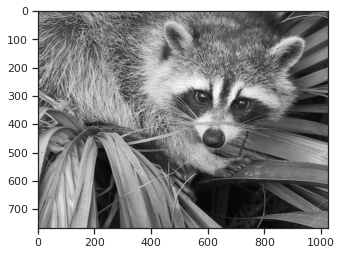

768


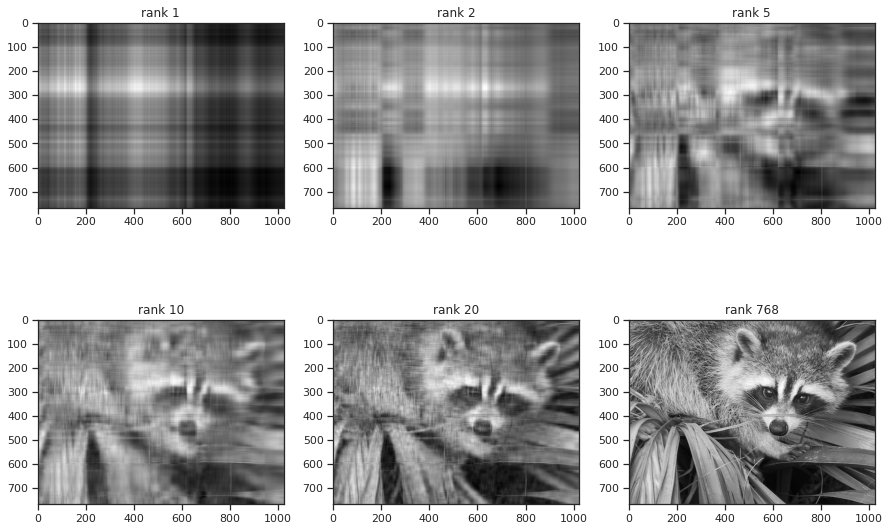

In [ ]:
import matplotlib.image

def rgb2gray(rgb):
  #Y' = 0.2989 R + 0.5870 G + 0.1140 B 
  return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

#url = 'https://github.com/probml/pyprobml/blob/master/data/clown.png'
#img = matplotlib.image.imread(url) # invalid png file, apparently...
#X = rgb2gray(img)    

import scipy
racoon = scipy.misc.face().astype(np.float)
X = rgb2gray(racoon)
plt.gray()
plt.imshow(X)
plt.show()

r = np.linalg.matrix_rank(X)
print(r)

U, sigma, V = jnp.linalg.svd(X, full_matrices=True)
ranks = [1, 2, 5, 10, 20, r]
R = len(ranks)

fig, axes = plt.subplots(2, 3, figsize=[15, 10])
axes = axes.reshape(-1)
for i in range(R):
    k = ranks[i] 
    x_hat = jnp.dot(jnp.dot(U[:, :k], jnp.diag(sigma[:k])), V[:k, :]) 
    ax = axes[i]
    #plt.subplot(2, 3, i+1)
    ax.imshow(x_hat, cmap='gray')
    ax.set_title("rank {}".format(k))
    #save_fig("svdImageDemoClown{}.pdf".format(k))
plt.show()



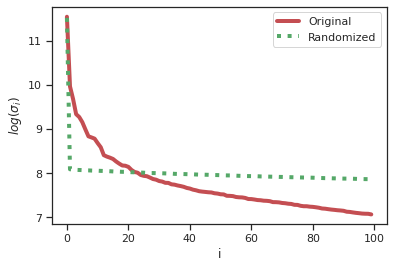

In [ ]:
# Plot singular value spectrum
k = 100
plt.figure()
plt.plot(jnp.log(sigma[:k]), 'r-', linewidth=4, label="Original")
plt.ylabel(r"$log(\sigma_i)$")
plt.xlabel("i")


# Compare this to a random shuffled version of the image
x2 = np.random.permutation(X)
# so we convert to a 1d vector, permute, and convert back
x1d = X.ravel()
np.random.shuffle(x1d) # ijnplace
x2 = x1d.reshape(X.shape)
U, sigma2, V = jnp.linalg.svd(x2, full_matrices = False)
plt.plot(jnp.log(sigma2[:k]), 'g:', linewidth=4, label="Randomized")
plt.legend()
#save_fig("svdImageDemoClownSigmaScrambled.pdf")
plt.show()

## Other matrix decompositions <a class="anchor" id="decomp"></a>

In this section, we illustrate a few other matrix decompositions.

### LU decomposition <a class="anchor" id="decomp-LU"></a>

In [ ]:

np.random.seed(42)
A = np.random.randn(5,5)
L, U = scipy.linalg.lu(A, True)
print(L)
print(U)

[[ 0.339 -0.04   0.733  1.     0.   ]
 [-0.16   1.     0.     0.     0.   ]
 [-0.316 -0.348  0.597 -0.423  1.   ]
 [-0.384 -0.712  1.     0.     0.   ]
 [ 1.     0.     0.     0.     0.   ]]
[[ 1.466 -0.226  0.068 -1.425 -0.544]
 [ 0.     1.543  0.778 -0.697  0.456]
 [ 0.     0.     0.895 -1.951 -1.297]
 [ 0.     0.     0.     3.409  0.919]
 [ 0.     0.     0.     0.    -0.576]]


### QR decomposition <a class="anchor" id="decomp-QR"></a>



In [ ]:
# Economy vs full mode

np.random.seed(42)
A = np.random.randn(5,3)
Q, R = scipy.linalg.qr(A, mode='economic')
print("economy: Q shape {}, R shape {}".format(Q.shape, R.shape))
print(Q)
print(R)


Q, R = scipy.linalg.qr(A, mode='full')
print("full: Q shape {}, R shape {}".format(Q.shape, R.shape))
print(Q)
print(R)
assert jnp.allclose(jnp.eye(5), jnp.dot(Q, Q.T), atol=1e-3)

economy: Q shape (5, 3), R shape (3, 3)
[[-0.213 -0.068  0.765]
 [-0.655 -0.119  0.303]
 [-0.679  0.35  -0.49 ]
 [-0.233 -0.221  0.004]
 [-0.104 -0.9   -0.29 ]]
[[-2.327 -0.031  0.622]
 [ 0.     2.13   1.474]
 [ 0.     0.     1.152]]
full: Q shape (5, 5), R shape (5, 3)
[[-0.213 -0.068  0.765 -0.018  0.604]
 [-0.655 -0.119  0.303 -0.248 -0.635]
 [-0.679  0.35  -0.49  -0.046  0.418]
 [-0.233 -0.221  0.004  0.943 -0.085]
 [-0.104 -0.9   -0.29  -0.215  0.222]]
[[-2.327 -0.031  0.622]
 [ 0.     2.13   1.474]
 [ 0.     0.     1.152]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]]


### Cholesky decomposition <a class="anchor" id="decomp-chol"></a>

In [ ]:
# Sample from multivariate Gaussian

from scipy.stats import multivariate_normal as mvn

def sample_mvn(mu, Sigma, N):
    L = jnp.linalg.cholesky(Sigma)
    D = len(mu)
    Z = np.random.randn(N, D)
    X = jnp.dot(Z, L.T) + jnp.reshape(mu, (-1,D))
    return X

D = 5
np.random.seed(42)
mu = np.random.randn(D)
A = np.random.randn(D,D)
Sigma = jnp.dot(A, A.T)
N = 10000
X = sample_mvn(mu, Sigma, N)
mu_hat = jnp.mean(X)
C = np.cov(X, rowvar=False) # not yet implemented by jax
print(C)
print(Sigma)
assert jnp.allclose(C, Sigma, 1e-0) # not that close, even after 10k samples...

dist = mvn(mu, Sigma)
X = dist.rvs(size=N)
C = np.cov(X, rowvar=False)
assert jnp.allclose(C, Sigma, 1e-0)
    

[[ 3.762 -0.445 -1.572 -0.246 -1.439]
 [-0.445  7.072  4.914  3.109  2.191]
 [-1.572  4.914  4.203  1.467  2.151]
 [-0.246  3.109  1.467  4.522  1.431]
 [-1.439  2.191  2.151  1.431  1.896]]
[[ 3.652 -0.479 -1.567 -0.274 -1.432]
 [-0.479  7.126  4.982  3.107  2.228]
 [-1.567  4.982  4.26   1.488  2.179]
 [-0.274  3.107  1.488  4.53   1.462]
 [-1.432  2.228  2.179  1.462  1.924]]


## Matrix calculus <a class="anchor" id="calculus"></a>

### Automatic differentiation in Jax  <a class="anchor" id="AD-jax"></a>

In this section, we show how to use Jax to compute gradients, Jacobians and Hessians
of some simple convex functions.

In [ ]:
from jax import grad, hessian, jacfwd, jacrev, vmap, jit

Linear function: multi-input, scalar output.

$$
\begin{align}
f(x; a) &= a^T x\\
\nabla_x f(x;a) &= a
\end{align}
$$


In [ ]:
# We construct a single output linear function.
# In this case, the Jacobian and gradient are the same.
Din = 3; Dout = 1;
np.random.seed(42)
a = np.random.randn(Dout, Din)
def fun1d(x):
    return jnp.dot(a, x)[0]
x = np.random.randn(Din)
g = grad(fun1d)(x)
assert jnp.allclose(g, a)
J = jacrev(fun1d)(x)
assert jnp.allclose(J, g)


Linear function: multi-input, multi-output.

$$
\begin{align}
f(x;A) &= A x \\
\nabla_x f(x;A) &= A
\end{align}
$$

In [ ]:
# We construct a multi-output linear function.
# We check forward and reverse mode give same Jacobians.
Din = 3; Dout = 4;
A = np.random.randn(Dout, Din)
def fun(x):
    return jnp.dot(A, x)
x = np.random.randn(Din)
Jf = jacfwd(fun)(x)
Jr = jacrev(fun)(x)
assert jnp.allclose(Jf, Jr)
assert jnp.allclose(Jf, A)

Quadratic form.

$$
\begin{align}
f(x;A) &= x^T A x \\
\nabla_x f(x;A) &= (A+A^T) x \\
\nabla^2 x^2 f(x;A) &= A + A^T
\end{align}
$$

In [ ]:

D = 4
A = np.random.randn(D, D)
x = np.random.randn(D)
quadfun = lambda x: jnp.dot(x, jnp.dot(A, x))

J = jacfwd(quadfun)(x)
assert jnp.allclose(J, jnp.dot(A+A.T, x))

H1 = hessian(quadfun)(x)
assert jnp.allclose(H1, A+A.T)

def my_hessian(fun):
  return jacfwd(jacrev(fun))
H2 = my_hessian(quadfun)(x)
assert jnp.allclose(H1, H2)

## Solving linear systems of equations <a class="anchor" id="linear"></a>

### Square systems with unique solution <a class="anchor" id="linear-systems-square"></a>

In [ ]:
A = jnp.array([[3,2,-1], [2, -2, 4], [-1, 0.5, -1]])
b = jnp.array([1, -2, 0])
x  = jax.scipy.linalg.solve(A,b)
print(x)
print(jnp.dot(A, x) - b)

[ 1. -2. -2.]
[ 2.384e-07 -9.537e-07 -2.384e-07]


In [ ]:
# Now use LU decomposition and backsubstitution.

L, U = jax.scipy.linalg.lu(A, permute_l=True)
print(L)
print(U)
y = jax.scipy.linalg.solve_triangular(L, b, lower=True)
x = jax.scipy.linalg.solve_triangular(U, y, lower=False)
print(x)

[[ 1.     0.     0.   ]
 [ 0.667  1.     0.   ]
 [-0.333 -0.35   1.   ]]
[[ 3.     2.    -1.   ]
 [ 0.    -3.333  4.667]
 [ 0.     0.     0.3  ]]
[ 1. -2. -2.]


### Underconstrained systems: least norm solution <a class="anchor" id="linear-systems-under"></a>

We will compute the minimum norm solution.

In [ ]:
np.random.seed(42)
m = 3
n = 4
A = np.random.randn(m, n)
x = np.random.randn(n)
b = jnp.dot(A, x)

#x_least_norm = jax.scipy.linalg.lstsq(A, b)[0]
x_least_norm = scipy.linalg.lstsq(A, b)[0]
print(x_least_norm)
print(jnp.dot(A, x_least_norm) - b)
print(jnp.linalg.norm(x_least_norm, 2))


[ 1.162 -1.083 -1.26  -0.985]
[ 0.000e+00  0.000e+00 -7.451e-08]
2.2538505


If you look at the [source code for scipy.linalg.lstsq](https://github.com/scipy/scipy/blob/v0.19.0/scipy/linalg/basic.py#L892-L1058),
you will see that it just a Python wrapper
to some LAPACK code written in Fortran. LAPACK offers multiple methods for solving
linear systems, including `gelsd` (default), `gelss` , and `gelsy`. The first two methods use SVD, the latter uses QR decomposition. 

A lot of numpy and scipy functions are just wrappers to legacy libraries,
  written in Fortran or C++, since Python itself is too slow for
  efficient numerical computing.
  Confusingly, sometimes numpy and scipy offer different wrappers to the same
  underlying LAPACK functions, but with different interfaces.
  For example, as of 2018, `jnp.linalg.lstsq` and
  `scipy.linalg.lstsq` have been modified to behave the same.
  However,
  `jnp.linalg.qr` and `scipy.linalg.qr`
  have slightly different optional arguments and may give different
  results.
  
Jax does not yet implement lstsq, but does implement some of the underlying methods 
 [here](https://github.com/google/jax/blob/master/jax/scipy/linalg.py).
 Unlike the legacy code, this can run fast on GPUs and TPUs.

### Overconstrained systems: least squares solution <a class="anchor" id="linear-systems-over"></a>

In [ ]:
def naive_solve(A, b):
    return jax.numpy.linalg.inv(A.T @ A) @ A.T @ b
    #return jjnp.linalg.inv(A.T @ A) @ A.T @ b

def qr_solve(A, b):
    Q, R = jnp.linalg.qr(A) 
    Qb = jnp.dot(Q.T,b) 
    return jax.scipy.linalg.solve_triangular(R, Qb)

def lstsq_solve(A, b):
    return scipy.linalg.lstsq(A, b, rcond=None)[0]

def pinv_solve(A, b):
    return jnp.dot(jnp.linalg.pinv(A), b)
    
np.random.seed(42)
m = 4
n = 3
A = np.random.randn(m, n)
x = np.random.randn(n)
b = jnp.dot(A, x)


methods = list()
solns = list()
    
methods.append('naive')
solns.append(naive_solve(A, b))

#methods.append('pinv')
#solns.append(pinv_solve(A,b)) # pinv not yet implemented by jax

#methods.append('lstsq')
#solns.append(lstsq_solve(A, b)) # lstsq not yet implemented by jax

methods.append('qr')
solns.append(qr_solve(A, b))


for (method, soln) in zip(methods, solns):
    residual = b -  jnp.dot(A, soln)
    print('method {}, norm {:0.5f}, residual {:0.5f}'.format(method, jnp.linalg.norm(soln), jnp.linalg.norm(residual)))
    print(soln.T)
    print('\n')

method naive, norm 2.58738, residual 0.00000
[ 0.242 -1.913 -1.725]


method qr, norm 2.58738, residual 0.00000
[ 0.242 -1.913 -1.725]


